In [4]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
import random
import warnings

warnings.filterwarnings('ignore')
np.random.seed(42)

## 5 covariates

### p: Edge probability in ER network (p of $G(n,p)$) $p \in [0,1]$
### $\tau$ : Normalized Neighbor threshold $\tau \in [0,1]$
### N: Number of agents  (n of $G(n,p)$) $N \in (0,100]$
### $N_E$: Number of events $N_E \in \{10,50\}$
### g: Grid subdivision parameter in agent neighborhood $g \in \{1,2,4,16\}$


### Ouput of interest: Fraction of agents in state 1 (Migrated) at the end of simulation
### Each point in a plot is averaged over >=100 scenarios, to account for stochasticity in event and agent location

## analyze results

In [24]:
%%time

# code for reading results from internal directories

# import os

# all_results = []

# for file in os.listdir('./sim-results-beta/'):
#     df = pd.read_csv('./sim-results-beta/'+file)
#     all_results.append(df)

# all_results = pd.concat(all_results)
# all_results

# all_results.to_parquet('all-results-coastal-env.pq',index=False)

# use this code to load all the pre-computed results

all_results = pd.read_parquet('all-results-coastal-env.pq')

CPU times: user 82.4 ms, sys: 99.7 ms, total: 182 ms
Wall time: 353 ms


In [25]:
all_results.shape

(2498400, 7)

In [26]:
all_results[all_results.P==0.9]['MIGRATE'].unique()

array([0.  , 1.  , 0.02, 0.01, 0.04, 0.08, 0.05, 0.06, 0.03])

In [27]:
# len([0.4, 0.97, 0.86, 0.92, 0.1428571428571428, 0.0612244897959183, 0.8775510204081632, 0.85, 0.5510204081632653, 0.95, 0.78, 0.8571428571428571, 0.3469387755102041, 0.2857142857142857, 0.9183673469387754, 0.4081632653061224, 0.62, 0.9591836734693876, 0.0408163265306122, 0.1, 1.0, 0.5, 0.3673469387755101, 0.2448979591836734, 0.979591836734694, 0.81, 0.7, 0.2040816326530612, 0.96, 0.3877551020408163, 0.0204081632653061, 0.183673469387755, 0.4693877551020408, 0.7755102040816326, 0.76, 0.1632653061224489, 0.7551020408163265, 0.3265306122448979, 0.6938775510204082, 0.91, 0.0816326530612244, 0.87, 0.1224489795918367, 0.98, 0.89, 0.68, 0.673469387755102, 0.5714285714285714, 0.6530612244897959, 0.2653061224489795, 0.88, 0.2244897959183673, 0.93, 0.8163265306122448, 0.0, 0.836734693877551, 0.3061224489795918, 0.9, 0.7346938775510203, 0.5306122448979591, 0.72, 0.1020408163265306, 0.58, 0.4489795918367346, 0.84, 0.8, 0.6326530612244897, 0.8979591836734693, 0.9387755102040816, 0.83, 0.74, 0.75, 0.54, 0.7959183673469387, 0.3, 0.4285714285714285, 0.82, 0.7142857142857142, 0.99, 0.5918367346938775, 0.66, 0.94, 0.4897959183673469, 0.6122448979591836, 0.2, 0.5102040816326531])

## observe the effect for low intensity (num_events = 10), low P

In [28]:
print('P',all_results['P'].unique().tolist())
print('T',all_results['T'].unique().tolist())
#print(all_results['SCENE_IDX'].unique().tolist()) # 100 scenes, just to average over stochastic events
print('N',all_results['N'].unique().tolist())
print('GRIDS',all_results['GRIDS'].unique().tolist())
print('NUM_EVENTS',all_results['NUM_EVENTS'].unique().tolist())

P [0.1, 0.05, 0.3, 0.5, 0.2, 0.9, 0.07, 0.25, 0.4, 0.15]
T [0.87, 0.0816326530612244, 0.0408163265306122, 0.7346938775510203, 0.3265306122448979, 0.6938775510204082, 0.3673469387755101, 0.83, 0.673469387755102, 1.0, 0.98, 0.2448979591836734, 0.7142857142857142, 0.5306122448979591, 0.54, 0.4489795918367346, 0.4693877551020408, 0.5, 0.86, 0.3061224489795918, 0.88, 0.9183673469387754, 0.1632653061224489, 0.1, 0.4081632653061224, 0.4285714285714285, 0.7, 0.0612244897959183, 0.183673469387755, 0.8775510204081632, 0.89, 0.78, 0.99, 0.75, 0.6122448979591836, 0.2653061224489795, 0.5510204081632653, 0.0204081632653061, 0.1020408163265306, 0.2, 0.97, 0.2857142857142857, 0.836734693877551, 0.1428571428571428, 0.93, 0.8163265306122448, 0.66, 0.8979591836734693, 0.8, 0.96, 0.76, 0.62, 0.5714285714285714, 0.4, 0.68, 0.9591836734693876, 0.94, 0.81, 0.3469387755102041, 0.0, 0.3, 0.95, 0.58, 0.74, 0.84, 0.7959183673469387, 0.85, 0.6326530612244897, 0.2244897959183673, 0.1224489795918367, 0.938775510204

In [29]:
%%time
avg_results = (all_results.groupby(['P','T','N','GRIDS','NUM_EVENTS'])['MIGRATE'].mean().reset_index()).rename(columns={'MIGRATE':'MIGRATE_AVG'})
median_results = (all_results.groupby(['P','T','N','GRIDS','NUM_EVENTS'])['MIGRATE'].median().reset_index()).rename(columns={'MIGRATE':'MIGRATE_MEDIAN'})
q1_results = (all_results.groupby(['P','T','N','GRIDS','NUM_EVENTS'])['MIGRATE'].quantile(q=0.25).reset_index()).rename(columns={'MIGRATE':'MIGRATE_q1'})
q3_results = (all_results.groupby(['P','T','N','GRIDS','NUM_EVENTS'])['MIGRATE'].quantile(q=0.75).reset_index()).rename(columns={'MIGRATE':'MIGRATE_q3'})
std_results = (all_results.groupby(['P','T','N','GRIDS','NUM_EVENTS'])['MIGRATE'].std().reset_index()).rename(columns={'MIGRATE':'MIGRATE_STD'})
avg_std_results = avg_results.merge(std_results,on=['P','T','N','GRIDS','NUM_EVENTS'],how='inner')
quantile_results = median_results.merge(q1_results.merge(q3_results,on=['P','T','N','GRIDS','NUM_EVENTS'],how='inner'),on=['P','T','N','GRIDS','NUM_EVENTS'],how='inner')

CPU times: user 1.11 s, sys: 165 ms, total: 1.28 s
Wall time: 1.8 s


In [30]:
import seaborn as sns
import datetime
from matplotlib import rcParams
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.dates as mdates
from mpl_toolkits import mplot3d
import numpy as np
import matplotlib.pyplot as plt

def createplot_t_grid_n_vs_mig(event_data,P=0.07,Scenario=100,Event=10,draw_type='quantile'):
    rcParams["font.size"] = 48
    rcParams["axes.labelsize"] = 44
    rcParams["axes.titlesize"] = 44
    rcParams["xtick.labelsize"] = 40
    rcParams["ytick.labelsize"] = 40
    
    lgd_params = {'hlen':1,'bpad':0.2,'lspace':0.2,'htxtpad':0.2,'baxpad':0.2,'cspace':0.2,'ncol':1,'ecolor':'black','size':28,'alpha':0.2}
    
    N_list = event_data['N'].unique().tolist()
    DIV = 2#len(N_list)//2+(len(N_list)%2)
    fig,ax = plt.subplots(1,DIV,figsize=(8*DIV,6),sharex=True,squeeze=False)
    
    for idx, n in enumerate(event_data['N'].unique().tolist()):

        cur_agent_result = event_data[event_data.N==n]
        grid_cols = ['#1b9e77','#d95f02','#7570b3','#e7298a']
        
        for colidx, g in enumerate(cur_agent_result['GRIDS'].unique().tolist()):
            x = cur_agent_result[cur_agent_result['GRIDS']==g]['T']
            if draw_type=='quantile':
                y = cur_agent_result[cur_agent_result['GRIDS']==g]['MIGRATE_MEDIAN']
                y_low = cur_agent_result[cur_agent_result['GRIDS']==g]['MIGRATE_q1']
                y_high = cur_agent_result[cur_agent_result['GRIDS']==g]['MIGRATE_q3']
            else:
                y = cur_agent_result[cur_agent_result['GRIDS']==g]['MIGRATE_AVG']
                y_low = y - cur_agent_result[cur_agent_result['GRIDS']==g]['MIGRATE_STD']
                y_high = y + cur_agent_result[cur_agent_result['GRIDS']==g]['MIGRATE_STD']
            ax[idx//DIV][idx%DIV].plot(x,y,label='$g$='+str(int(g)),linewidth=4,marker='o',color=grid_cols[colidx])
            ax[idx//DIV][idx%DIV].fill_between(x,y_low,y_high,linewidth=2,color=grid_cols[colidx],alpha=0.2)
        
        ax[idx//DIV][idx%DIV].set_title('N='+str(int(n)))
        #ax[idx//DIV][idx%DIV].legend(loc='best',fontsize=26)
        ax[idx//DIV][idx%DIV].legend(loc="best", fancybox=True, handlelength=lgd_params['hlen'], borderpad=lgd_params['bpad'], labelspacing=lgd_params['lspace'],
                  handletextpad = lgd_params['htxtpad'], borderaxespad = lgd_params['baxpad'], columnspacing = lgd_params['cspace'],
                  ncol=lgd_params['ncol'], edgecolor=lgd_params['ecolor'], frameon=True, framealpha=lgd_params['alpha'], shadow=False, prop={'size': lgd_params['size']})
        ax[idx//DIV][idx%DIV].set_xlabel('$\\tau$')
        if idx==0:
            ax[idx//DIV][idx%DIV].set_ylabel('Fraction of\nMigrants')
        ax[idx//DIV][idx%DIV].set_xlim([0,1.0])
        ax[idx//DIV][idx%DIV].set_ylim([0,1.2])
        ax[idx//DIV][idx%DIV].set_xticks([0,0.2,0.5,0.8,1])
        ax[idx//DIV][idx%DIV].set_xticklabels([0,0.2,0.5,0.8,1])
        ax[idx//DIV][idx%DIV].set_yticks([0.5,1.0])

    #plt.suptitle(f'p = {P}, {Scenario} replicates per point, each replicate wih $n_E=${Event}, {draw_type} plot', fontsize=32)
    fig.tight_layout()
    fig.savefig(f'Figures/p-{round(P,2)}-{Event}-{draw_type}.pdf',bbox_inches='tight',dpi=350)
    
def createcloud(event_data,P=0.07,Scenario=100,Event=10,draw_type='cloud'):
    rcParams["font.size"] = 48
    rcParams["axes.labelsize"] = 44
    rcParams["axes.titlesize"] = 44
    rcParams["xtick.labelsize"] = 40
    rcParams["ytick.labelsize"] = 40
    
    N_list = event_data['N'].unique().tolist()
    DIV = len(N_list)//2+(len(N_list)%2)
    fig,ax = plt.subplots(2,DIV,figsize=(10*DIV,8*2))

    cols = ['#ffffe5','#fee391','#fe9929','#cc4c02','#662506']

    for idx, n in enumerate(event_data['N'].unique().tolist()):

        cur_agent_result = event_data[event_data.N==n]

        grid_cols = ['#1b9e77','#d95f02','#7570b3','#e7298a']

        for colidx, g in enumerate(cur_agent_result['GRIDS'].unique().tolist()):
            x = cur_agent_result[cur_agent_result['GRIDS']==g]['T']
            y = cur_agent_result[cur_agent_result['GRIDS']==g]['MIGRATE']
            #y_e = cur_agent_result[cur_agent_result['GRIDS']==g]['MIGRATE_STD']
            #ax[idx//DIV][idx%DIV].errorbar(x,y,yerr=y_e,label='GRIDS='+str(g),linewidth=4,elinewidth=2,marker='o',color=grid_cols[colidx])
            ax[idx//DIV][idx%DIV].scatter(x,y,color=grid_cols[colidx],alpha=0.05,s=100)
        for colidx, g in enumerate(cur_agent_result['GRIDS'].unique().tolist()):
            x = cur_agent_result[cur_agent_result['GRIDS']==g]['T']
            y = [-100]*(x.shape[0])
            #y_e = cur_agent_result[cur_agent_result['GRIDS']==g]['MIGRATE_STD']
            #ax[idx//DIV][idx%DIV].errorbar(x,y,yerr=y_e,label='GRIDS='+str(g),linewidth=4,elinewidth=2,marker='o',color=grid_cols[colidx])
            ax[idx//DIV][idx%DIV].scatter(x,y,label='$g$='+str(int(g)),color=grid_cols[colidx],alpha=1,s=100)
        ax[idx//DIV][idx%DIV].set_title('n='+str(int(n)))
        ax[idx//DIV][idx%DIV].legend(loc='best',fontsize=30)
        ax[idx//DIV][idx%DIV].set_xlabel('$\\pi$')
        if idx==0:
            ax[idx//DIV][idx%DIV].set_ylabel('Avg $\\frac{\\sum{M_a(T)}}{n}$')
        ax[idx//DIV][idx%DIV].set_xlim([0,1.5])
        ax[idx//DIV][idx%DIV].set_ylim([0,1.2])
        ax[idx//DIV][idx%DIV].set_xticks([0,0.2,0.4,0.6,0.8,1.0])

    plt.suptitle(f'p = {P}, $n_E=${Event}, {draw_type} plot', fontsize=32)
    fig.tight_layout()
    fig.savefig(f'Figures/p-{round(P,2)}-{Event}-cloud.pdf',bbox_inches='tight',dpi=350)
    
def create_transition_plot(event_data,P=0.07,Grid=1,Event=10,Scenario=100,data_type='MEDIAN',TOPK=5):
    
    fig,ax = plt.subplots(figsize=(7,5))
    
    for n in event_data['N'].unique().tolist():
        #if (n>50):
        #    continue
        subset_event  = event_data[event_data.N==n]
        subset_event = subset_event.sort_values(by='T')
        subset_event['drop'] = (subset_event['MIGRATE_'+data_type].diff())*(-1)
        ax.plot(subset_event['T'],subset_event['drop'],label='N = '+str(n),alpha=0.3)
        
        subset_event = subset_event.sort_values(by='drop',ascending=False)
        print(n,subset_event[0:TOPK]['T'].tolist())
        
    ax.set_xlabel('$\\pi$')
    ax.set_ylabel('$\\frac{\\partial {y}}{\\partial {\\pi}}$')
    ax.set_title(f'Setting: p = {P}, g = {Grid}, $n_E$ = {Event}')
    ax.legend(loc='best',fontsize=10)
    fig.tight_layout()
    


## $p$ = 0.05, $N_E$ = 10

In [32]:
low_p_low_event_results_A = avg_std_results[(avg_std_results.P==0.05) & (avg_std_results.NUM_EVENTS==10) & (avg_std_results.N%50==0)]
low_p_low_event_results_B = quantile_results[(quantile_results.P==0.05) & (quantile_results.NUM_EVENTS==10) & (avg_std_results.N%50==0)]

### Mean-Std Plot

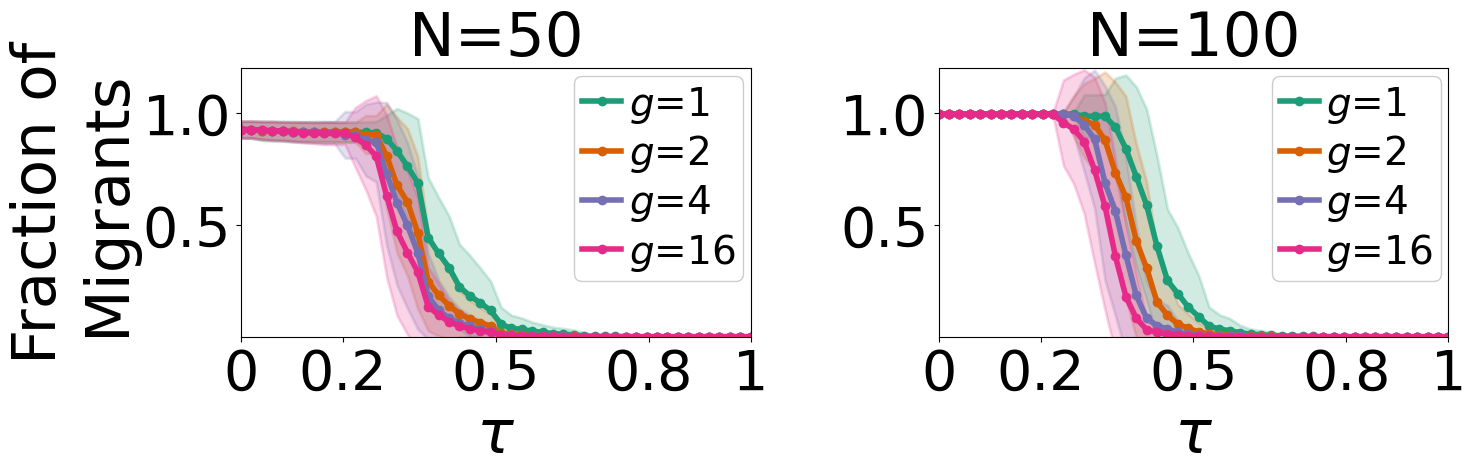

In [33]:
createplot_t_grid_n_vs_mig(low_p_low_event_results_A,P=0.05,draw_type='mean-std')

## median-q1-q3-plot

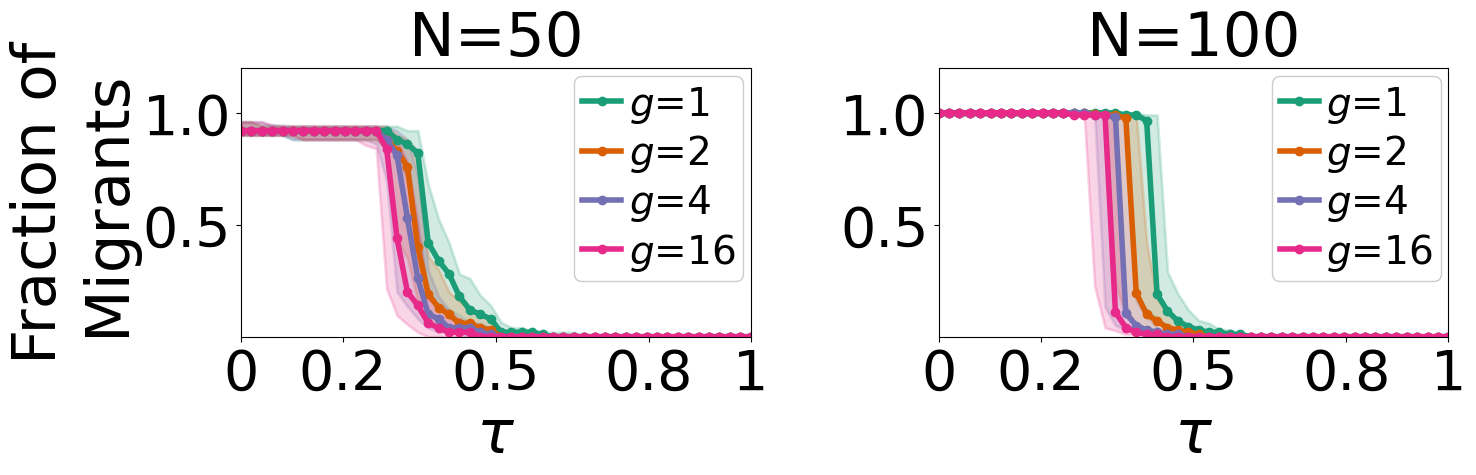

In [34]:
createplot_t_grid_n_vs_mig(low_p_low_event_results_B,P=0.05,draw_type='quantile')

## Sparse Graph, but event intensive environment
## Avg-STD Plot

In [35]:
low_p_high_event_results_A = avg_std_results[(avg_std_results.P==0.05) & (avg_std_results.NUM_EVENTS==50) & (avg_std_results.N%50==0)]
low_p_high_event_results_B = quantile_results[(quantile_results.P==0.05) & (quantile_results.NUM_EVENTS==50) & (avg_std_results.N%50==0)]

#createplot_t_grid_n_vs_mig(low_p_high_event_results_A,P=0.05,Event=50,draw_type='avg')

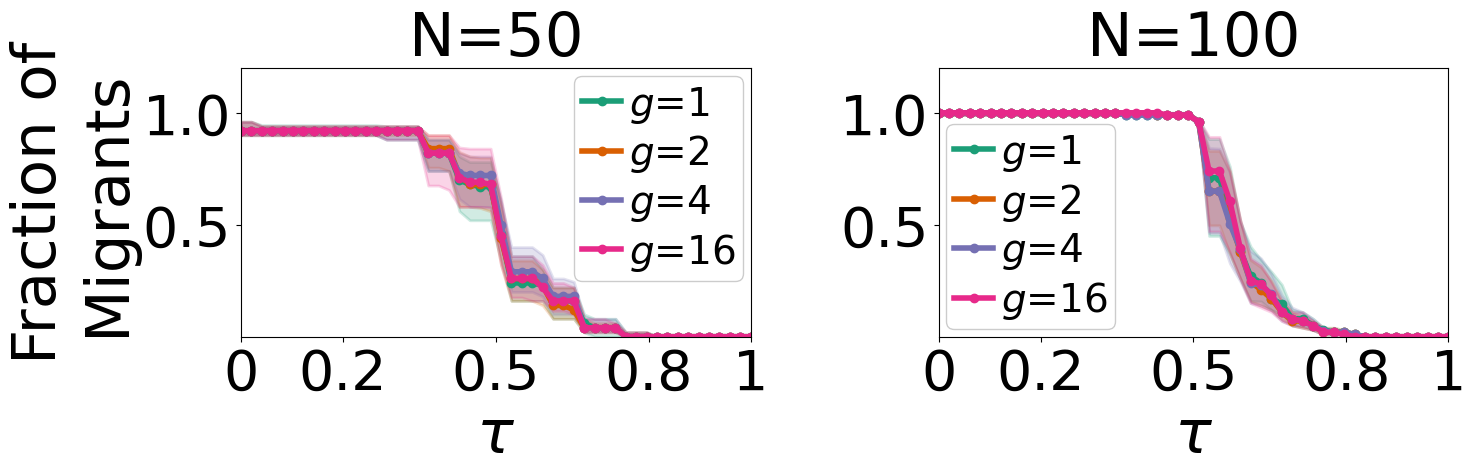

In [36]:
createplot_t_grid_n_vs_mig(low_p_high_event_results_B,P=0.05,Event=50,draw_type='quantile')

## for all p,event combination, plot the same thing as a cloud

In [88]:
# %%time
# all_PS = [0.05,0.07,0.1,0.2,0.25,0.3,0.4,0.5]
# all_ES = [10,50]

# for p in all_PS:
#     for e in all_ES:
#         print(p,e)
#         cloud = all_results[(all_results.P==p) & (all_results.NUM_EVENTS==e)]
#         cloud = cloud.sort_values(by='N')
#         createcloud(cloud,P=p,Event=e)

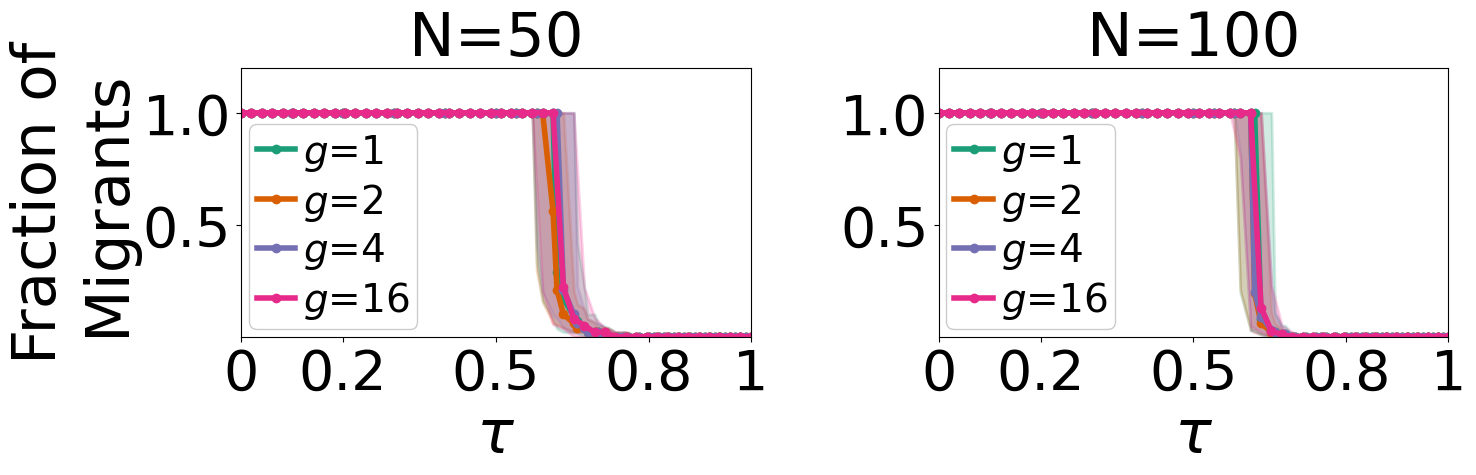

In [37]:
#low_p_low_event_results_A = avg_std_results[(avg_std_results.P==0.05) & (avg_std_results.NUM_EVENTS==10)]
med_p_high_event_results_B = quantile_results[(quantile_results.P==0.3) & (quantile_results.NUM_EVENTS==50) & (quantile_results.N%50==0)]
createplot_t_grid_n_vs_mig(med_p_high_event_results_B,P=0.3,Event=50)
#create

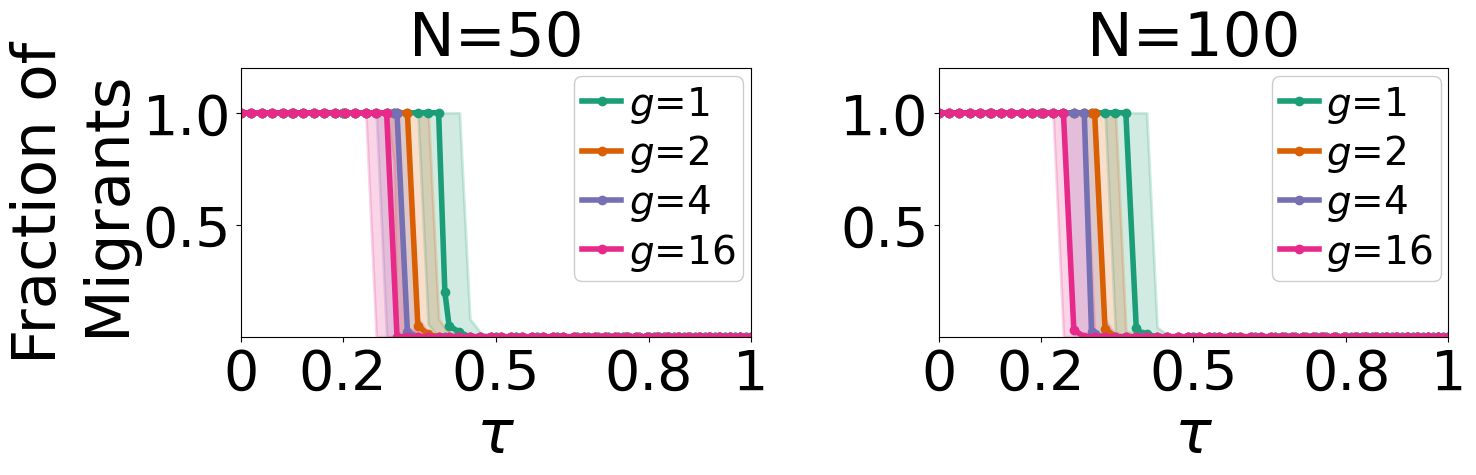

In [42]:
#low_p_low_event_results_A = avg_std_results[(avg_std_results.P==0.05) & (avg_std_results.NUM_EVENTS==10)]
med_p_low_event_results_B = quantile_results[(quantile_results.P==0.3) & (quantile_results.NUM_EVENTS==10) & (quantile_results.N%50==0)]
createplot_t_grid_n_vs_mig(med_p_low_event_results_B,P=0.3,Event=10)
#create

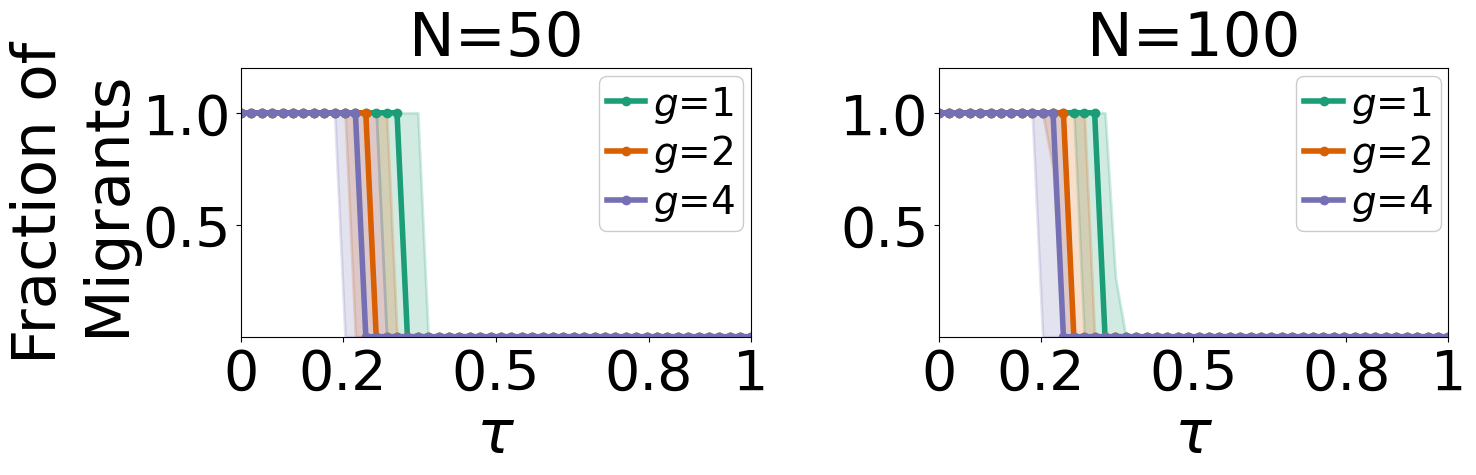

In [44]:
#low_p_low_event_results_A = avg_std_results[(avg_std_results.P==0.05) & (avg_std_results.NUM_EVENTS==10)]
high_p_low_event_results_B = quantile_results[(quantile_results.P==0.9) & (quantile_results.NUM_EVENTS==10) & (quantile_results.N%50==0)]
createplot_t_grid_n_vs_mig(high_p_low_event_results_B,P=0.9,Event=10)
#create

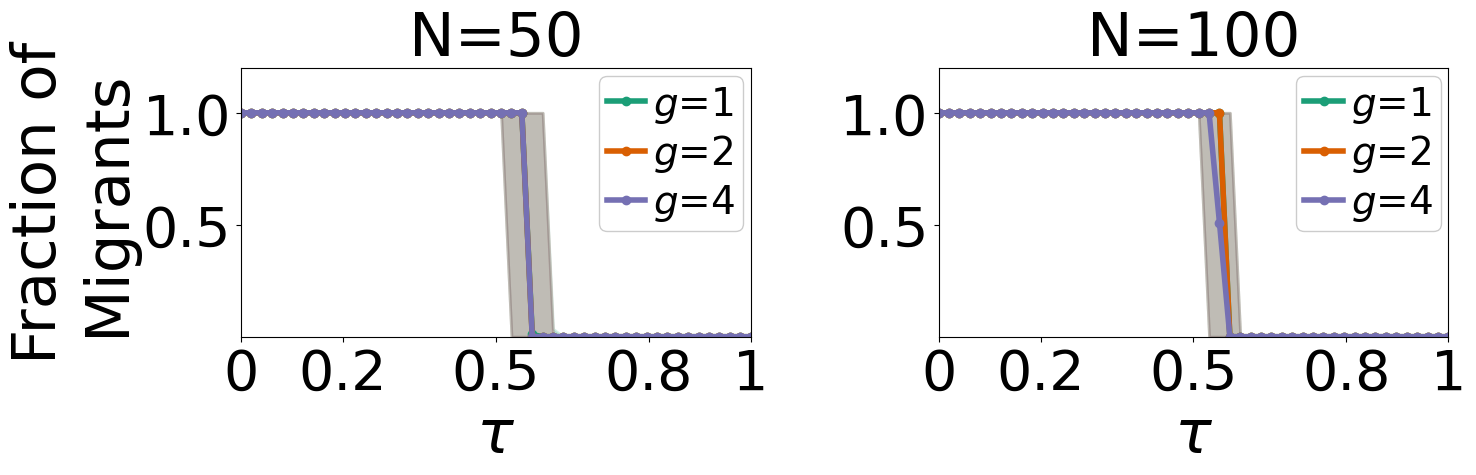

In [45]:
#low_p_low_event_results_A = avg_std_results[(avg_std_results.P==0.05) & (avg_std_results.NUM_EVENTS==10)]
high_p_high_event_results_B = quantile_results[(quantile_results.P==0.9) & (quantile_results.NUM_EVENTS==50) & (quantile_results.N%50==0)]
createplot_t_grid_n_vs_mig(high_p_high_event_results_B,P=0.9,Event=50)
#create

## at which point the change occurs

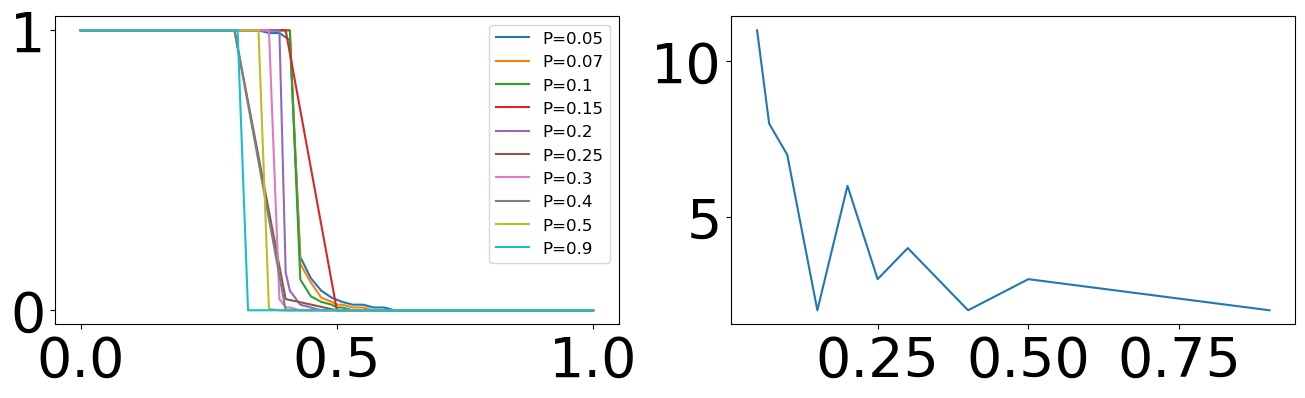

In [59]:
N_E = 10
N = 100
g = 1
cur_quantile = quantile_results[(quantile_results.N==N) & (quantile_results.NUM_EVENTS==N_E) & (quantile_results.GRIDS==g)]

fig,ax = plt.subplots(1,2,figsize=(16,4))

px = []
fixed_points = []

for p in quantile_results['P'].unique():
    cur_df = cur_quantile[cur_quantile.P==p][['T','MIGRATE_MEDIAN']].sort_values(by='T')
    ax[0].plot(cur_df['T'],cur_df['MIGRATE_MEDIAN'],label=f'P={round(p,2)}')
    px.append(p)
    fixed_points.append(cur_df['MIGRATE_MEDIAN'].unique().shape[0])
ax[0].legend(loc='best',fontsize=12)

ax[1].plot(px,fixed_points)

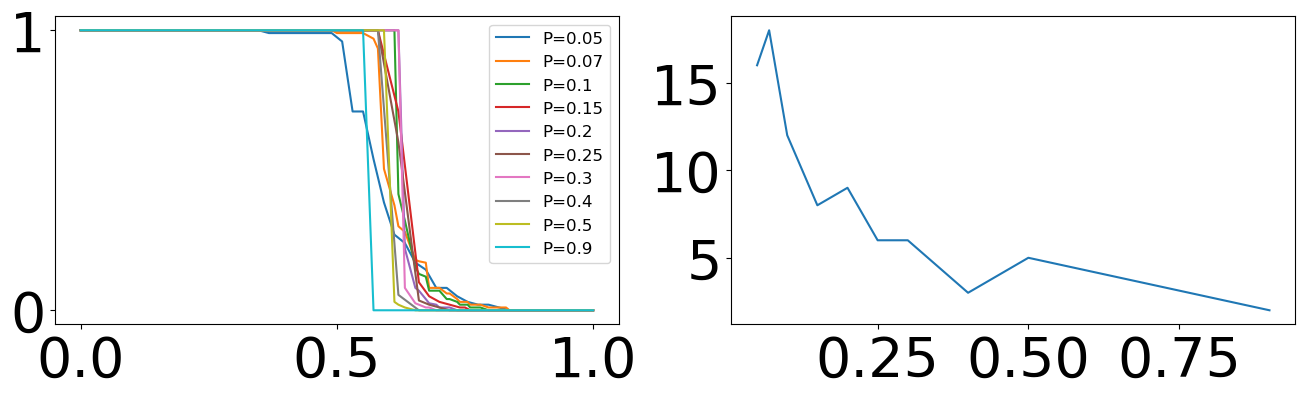

In [60]:
N_E = 50
N = 100
g = 1
cur_quantile = quantile_results[(quantile_results.N==N) & (quantile_results.NUM_EVENTS==N_E) & (quantile_results.GRIDS==g)]

fig,ax = plt.subplots(1,2,figsize=(16,4))

px = []
fixed_points = []

for p in quantile_results['P'].unique():
    cur_df = cur_quantile[cur_quantile.P==p][['T','MIGRATE_MEDIAN']].sort_values(by='T')
    ax[0].plot(cur_df['T'],cur_df['MIGRATE_MEDIAN'],label=f'P={round(p,2)}')
    px.append(p)
    fixed_points.append(cur_df['MIGRATE_MEDIAN'].unique().shape[0])
ax[0].legend(loc='best',fontsize=12)

ax[1].plot(px,fixed_points)

In [47]:
cur_df

,P,T,N,GRIDS,NUM_EVENTS,MIGRATE_MEDIAN,MIGRATE_q1,MIGRATE_q3
24,0.05,0.000000,50.0,1.0,10.0,0.92,0.900,0.960
72,0.05,0.020408,50.0,1.0,10.0,0.92,0.900,0.960
120,0.05,0.040816,50.0,1.0,10.0,0.92,0.900,0.945
168,0.05,0.061224,50.0,1.0,10.0,0.92,0.900,0.945
216,0.05,0.081633,50.0,1.0,10.0,0.92,0.900,0.940
264,0.05,0.102041,50.0,1.0,10.0,0.92,0.880,0.940
312,0.05,0.122449,50.0,1.0,10.0,0.92,0.880,0.940
360,0.05,0.142857,50.0,1.0,10.0,0.92,0.880,0.940
408,0.05,0.163265,50.0,1.0,10.0,0.92,0.880,0.940
456,0.05,0.183673,50.0,1.0,10.0,0.92,0.880,0.940


10.0 [0.2857142857142857]
20.0 [0.3265306122448979]
30.0 [0.2653061224489795]
50.0 [0.2857142857142857]
80.0 [0.3469387755102041]
100.0 [0.2857142857142857]


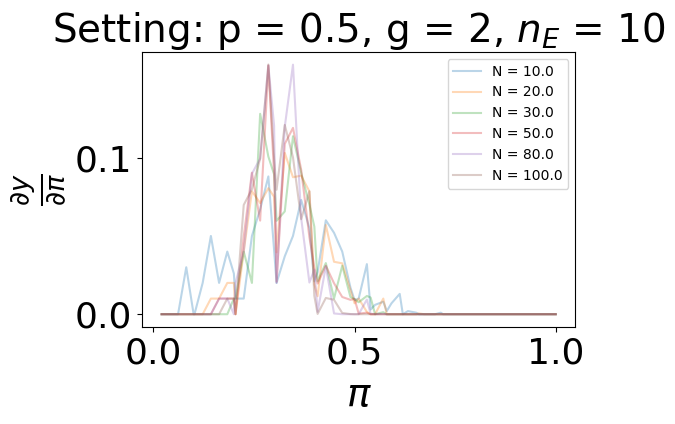

In [32]:
P = 0.5
GRID = 2
EVENT_NUM = 10
event_data_2 = avg_std_results[(avg_std_results.P==P) & (avg_std_results.GRIDS==GRID) & (avg_std_results.NUM_EVENTS==EVENT_NUM) & (avg_std_results.N>0)]

create_transition_plot(event_data_2,P=P,Grid=GRID,Event=EVENT_NUM,data_type='AVG',TOPK=1)


In [39]:
# import numpy as np
# import os
# p_space = [0.07,0.1,0.15,0.2,0.25,0.3,0.4,0.5,0.6,0.7,0.8,0.9]
# #low_p_space = [0.07,0.1,0.15,0.2,0.25,0.3,0.4,0.5]
# low_p_space = [0.05,0.1,0.2,0.3,0.5]
# n_space = [10,20,30,50,80,100]
# e_space = [10,50]
# #t_space = np.linspace(0,1,50)
# #t_space = [0,0.1,0.2,0.3,0.4,0.5,0.54,0.58,0.62,0.66,0.68,0.7,0.72,0.74,
# #          0.75,0.76,0.78,0.8,0.81,0.82,0.83,0.84,0.85,0.86,0.87,0.88,0.89,0.9,0.91,0.92,0.93,0.94,0.95,0.96,0.97,0.98,0.99,1.00]

# t_space = np.linspace(0,1,50)
# #t_space = [0,1/16,1/8,1/4,1/2,3/5,5/8,2/3,3/4,0.76,0.78,4/5,0.81,5/6,6/7,7/8,8/9,9/10]

# #g_space = [1.0,2.0,4.0]
# g_space = [16.0]

# for n in n_space:
#     for p in low_p_space:
#         for t in t_space:
#             for g in g_space:
#                 for e in e_space:
#                     name = f'./sim-results-beta/simulation-stat-n-{n}-p-{p}-t-{t}-g-{g}-ne-{e}-results.csv'
#                     #path = f'./sim-results-beta/{name}'
#                     #print(path)
#                     if os.path.isfile(name):
#                         #print('ache')
#                         continue
#                     else:
#                         print('sbatch setting-n-p-t-grid.sbatch',n,p,t,g,e)

# #f'sim-results-beta/simulation-stat-n-{NUM_AGENTS}-p-{P}-t-{THRESH}-g-{GRIDS}-ne-{NUM_EVENTS}-results.csv'